## Support Vector Machine - Face Recognition

In this recitation you will use Support Vector Machine (SVM) to solve a face recognition problem: given the picture of the face of an unknown person, identify the name of the person by referring to a gallery of previously seen pictures of identified persons.

### Dataset

You will use the Labeled Faces in the Wild (LFW) people dataset:
http://vis-www.cs.umass.edu/lfw/

Labeled Faces in the Wild (LFW) is a database of face photographs designed for studying the problem of unconstrained face recognition. This database was created and maintained by researchers at the University of Massachusetts, Amherst. 13,233 images of 5,749 people were detected and centered by the Viola Jones face detector and collected from the web. 1,680 of the people pictured have two or more distinct photos in the dataset. The original database contains four different sets of LFW images and also three different types of "aligned" images. According to the researchers, deep-funneled images produced superior results for most face verification algorithms compared to the other image types. Hence, the dataset is the deep-funneled version.

Each image is a 250 x 250 jpg, detected and centered using the openCV implementation of Viola-Jones face detector. 


### Load Dataset using Scikit-Learn

This dataset can be obtained by using the Scikit-Learn function: sklearn.datasets.fetch_lfw_people

Following are the relevant return attributes:

- data: numpy array of shape (13233, 2914)
        -- Each row corresponds to a ravelled face image of original size 62 x 47 pixels. Changing the slice_ or resize parameters will change the shape of the output.

- images : numpy array of shape (13233, 62, 47)
         -- Each row is a face image corresponding to one of the 5749 people in the dataset. Changing the slice_ or resize parameters will change the shape of the output.

- target : numpy array of shape (13233,)
        -- Labels associated to each face image. Those labels range from 0-5748 and correspond to the person IDs.
        
        
For this recitation you will use a **subset of this database**. Your subset will only retain pictures of people that have **at least 50 different pictures**. The subset will define a 12 class classification problem.

To ensure this, you will set the value of the "min_faces_per_person" attribute to 50. 

### Tasks:
1. Based on your reading of the notebook series on SVM (https://github.com/rhasanbd/Support-Vector-Machine-Classifier-Beginners-Survival-Kit), choose the best SVM model for this problem (choose from LinearSVC and Kernelized SVM).
2. [20 points] You will have to decide whether to do the following: scaling, dimensionality reduction by Principle Component Analysis (PCA)
        -- If you decide to use PCA, then you will have to find the optimal number of principle compoments. 
3. [50 points] Choose the optimal model hyperparameters via grid search. You will have to carefully set the range of values for the grid parameters. The SVM notebook series provide an extensive discussion on choosing the range of values for grid search. 
        -- You will loose points for using a too large range that lacks justification. Note that brute-force search defeats the whole purpose of intelligent learning.
4. [20 points] Display the model performance by confusion matrix and classification report. Additinally, you can generate heatmap plot of the confusion matrix using the seaborn library.
5. [10 points] Finally, answer the analytical questions.

Please note that your goal is to optimize the performance of your model. Thus, you will need to do careful planning and experimentation. 

The minumum "micro average" score for precision, recall, and f1 score (from classfication report) is 0.85.

If your "micro average" score is below 0.85, then irrespective of your work you will **loose maximum 50% of the points**.

In [105]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt


from sklearn.datasets import fetch_mldata
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Load Data

We will set the values of the "min_faces_per_person" attribute to 50. This will ensure that the extracted dataset will only retain pictures of people that have at least min_faces_per_person different pictures.

This subset will define a 12 class classification problem.

In [106]:
faces = fetch_lfw_people(min_faces_per_person=50)

X = faces.data
y = faces.target

print("\nLabel of the 12 Classes:\n", faces.target_names)
print("\nData Matrix Dimension: ", X.shape)
print("\nLength of the Class Label Array:", y.shape)


Label of the 12 Classes:
 ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Jacques Chirac' 'Jean Chretien'
 'John Ashcroft' 'Junichiro Koizumi' 'Serena Williams' 'Tony Blair']

Data Matrix Dimension:  (1560, 2914)

Length of the Class Label Array: (1560,)


## Visualize the Images

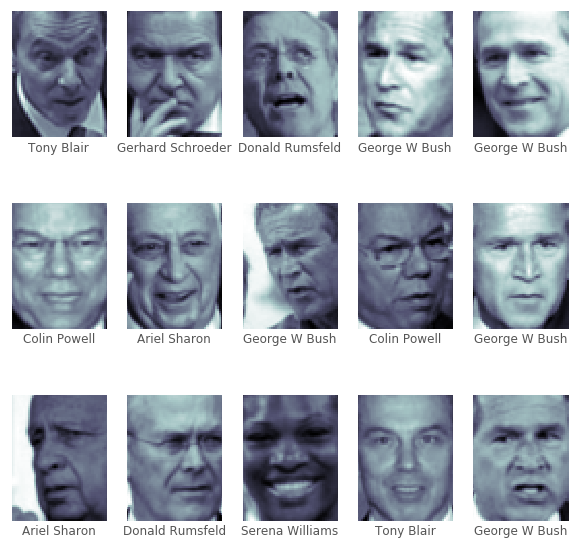

In [107]:
fig, ax = plt.subplots(3, 5)

fig.set_figheight(10)
fig.set_figwidth(10)

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

## Split Training and Test Data

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

shuffle_index = np.random.permutation(1100)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]


## Standardize the Data

PCA is influenced by scale of the data. Thus we need to scale the features of the data before applying PCA. 

In [109]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


## Apply PCA

In [110]:
%%time
pca = PCA(n_components=0.95)

pca.fit(X_train)

CPU times: user 704 ms, sys: 60.1 ms, total: 764 ms
Wall time: 408 ms


## Number of Principle Components

We can find how many components PCA chose after fitting the model by using the following attribute: n_components_

In [81]:
print("Numberof Principle Components: ", pca.n_components_)  

Numberof Principle Components:  154


In [53]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [54]:
%%time
param_grid = {
    'C': [0.1, 1, 5, 10],
}

LinearSVC = LinearSVC()
svm_linearsvc = GridSearchCV(LinearSVC, param_grid, scoring='accuracy', cv=5)

svm_linearsvc = svm_linearsvc.fit(X_train_pca, y_train)


print("\nBest Score: %f" % svm_linearsvc.best_score_)

print("\nOptimal Hyperparameter Values: ")

for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, svm_linearsvc.best_params_[param_name]))


Best Score: 0.708182

Optimal Hyperparameter Values: 
C: 0.1
CPU times: user 25.4 s, sys: 53.7 ms, total: 25.5 s
Wall time: 22.4 s


## Experiment 1: LinearSVC + PCA

In [57]:
%%time
linear_svc_pca = LinearSVC(loss='hinge', C=0.1, random_state=42)
linear_svc_pca.fit(X_train_pca, y_train)

CPU times: user 1.22 s, sys: 6.4 ms, total: 1.23 s
Wall time: 1.24 s


## Experiment 1: Evaluate LinearSVC + PCA on Test Data

In [58]:
%%time

y_test_predicted = linear_svc_pca.predict(X_test_pca)

accuracy_score_test = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", accuracy_score_test)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))


Test Accuracy:  0.741025641026

Test Confusion Matrix:
[[  9   2   0   1   0   0   0   1   1   0   1   1]
 [  0  54   1   3   0   2   2   0   0   1   3   0]
 [  1   0  14   4   4   0   0   1   1   0   1   1]
 [  2   3   5 111   2   1   3   2   3   3   2   3]
 [  0   0   0   1  16   2   0   2   0   1   0   2]
 [  0   0   0   4   2  10   0   0   0   0   1   0]
 [  0   0   0   3   1   1   4   0   0   0   0   1]
 [  0   1   0   0   0   0   0  13   0   0   0   0]
 [  0   0   0   1   0   0   0   0  14   1   0   0]
 [  0   0   0   0   0   0   0   0   1   8   1   1]
 [  0   1   0   1   0   0   0   0   1   0   6   0]
 [  0   1   0   3   4   0   0   1   0   1   0  30]]

Classification Report:
             precision    recall  f1-score   support

          0       0.75      0.56      0.64        16
          1       0.87      0.82      0.84        66
          2       0.70      0.52      0.60        27
          3       0.84      0.79      0.82       140
          4       0.55      0.67      0.6

## Experiment 2: LinearSVC

In [60]:
%%time
linear_svc = LinearSVC(loss='hinge', C=0.1, random_state=42)
linear_svc.fit(X_train, y_train)

CPU times: user 39 s, sys: 201 ms, total: 39.2 s
Wall time: 39.8 s


## Experiment 2: Evaluate LinearSVC on Test Data

In [61]:
%%time

y_test_predicted = linear_svc.predict(X_test)

accuracy_score_test = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", accuracy_score_test)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))


Test Accuracy:  0.74358974359

Test Confusion Matrix:
[[ 11   1   1   0   0   0   0   0   0   0   0   3]
 [  1  54   1   5   1   0   1   0   1   0   1   1]
 [  0   2  16   3   3   0   0   0   0   0   1   2]
 [  2   4   9 113   5   0   1   0   1   1   0   4]
 [  0   0   0   2  20   0   0   1   0   0   0   1]
 [  0   1   0   2   1  10   0   1   0   0   0   2]
 [  0   0   0   3   1   1   4   1   0   0   0   0]
 [  0   0   1   1   0   0   0  12   0   0   0   0]
 [  0   1   0   1   1   0   0   0  12   1   0   0]
 [  0   0   0   2   0   0   0   0   0   7   0   2]
 [  0   1   1   0   0   2   0   0   0   0   5   0]
 [  0   0   0   4   3   1   1   3   0   2   0  26]]

Classification Report:
             precision    recall  f1-score   support

          0       0.79      0.69      0.73        16
          1       0.84      0.82      0.83        66
          2       0.55      0.59      0.57        27
          3       0.83      0.81      0.82       140
          4       0.57      0.83      0.68

## Experiment 3: SVC (Linear Kernel) + PCA

In [62]:
%%time
svm_clf_pca = SVC(C=0.1, kernel='linear')
svm_clf_pca.fit(X_train_pca, y_train)

CPU times: user 221 ms, sys: 3.28 ms, total: 224 ms
Wall time: 226 ms


## Experiment 3: Evaluate SVC (Linear Kernel) + PCA on Test Data

In [63]:
%%time

y_test_predicted = svm_clf_pca.predict(X_test_pca)

accuracy_score_test = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", accuracy_score_test)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))


Test Accuracy:  0.810256410256

Test Confusion Matrix:
[[ 13   1   0   1   0   0   0   1   0   0   0   0]
 [  4  51   0   7   0   0   3   0   0   0   1   0]
 [  1   0  22   2   1   0   0   0   1   0   0   0]
 [  3   3   8 118   1   0   0   2   2   1   1   1]
 [  0   0   1   2  20   0   0   1   0   0   0   0]
 [  0   3   0   2   0  12   0   0   0   0   0   0]
 [  0   0   0   3   2   0   5   0   0   0   0   0]
 [  0   0   2   0   0   0   0  12   0   0   0   0]
 [  0   0   0   0   1   0   0   0  15   0   0   0]
 [  0   0   0   2   0   0   0   0   0   9   0   0]
 [  0   1   0   0   0   0   0   0   0   0   8   0]
 [  0   1   0   3   4   0   0   1   0   0   0  31]]

Classification Report:
             precision    recall  f1-score   support

          0       0.62      0.81      0.70        16
          1       0.85      0.77      0.81        66
          2       0.67      0.81      0.73        27
          3       0.84      0.84      0.84       140
          4       0.69      0.83      0.7

## Experiment 4: SVC (Linear Kernel)

In [64]:
%%time
svm_clf = SVC(C=0.1, kernel='linear')
svm_clf.fit(X_train, y_train)

CPU times: user 3.88 s, sys: 28.5 ms, total: 3.91 s
Wall time: 3.93 s


## Experiment 4: Evaluate SVC (Linear Kernel) on Test Data

In [65]:
%%time

y_test_predicted = svm_clf.predict(X_test)

accuracy_score_test = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", accuracy_score_test)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))


Test Accuracy:  0.841025641026

Test Confusion Matrix:
[[ 13   2   0   0   0   0   0   1   0   0   0   0]
 [  2  58   0   3   0   0   2   0   0   0   1   0]
 [  1   0  21   2   1   0   0   1   1   0   0   0]
 [  2   2   8 122   0   0   0   2   1   1   1   1]
 [  0   0   2   2  19   0   0   1   0   0   0   0]
 [  0   2   0   2   1  12   0   0   0   0   0   0]
 [  0   0   0   2   2   0   6   0   0   0   0   0]
 [  0   1   0   0   0   0   0  13   0   0   0   0]
 [  0   0   0   0   1   0   0   0  15   0   0   0]
 [  0   1   0   1   0   0   0   0   0   9   0   0]
 [  0   1   0   0   0   0   0   0   0   0   8   0]
 [  0   1   0   3   4   0   0   0   0   0   0  32]]

Classification Report:
             precision    recall  f1-score   support

          0       0.72      0.81      0.76        16
          1       0.85      0.88      0.87        66
          2       0.68      0.78      0.72        27
          3       0.89      0.87      0.88       140
          4       0.68      0.79      0.7

In [68]:
%%time
param_grid = {
    'C': [0.1, 1, 5, 10],
    'gamma': [0.1, 0.01, 0.001],
}

SVC = SVC()
svc = GridSearchCV(SVC, param_grid, scoring='accuracy', cv=5)

svc = svc.fit(X_train_pca, y_train)


print("\nBest Score: %f" % svm_linearsvc.best_score_)

print("\nOptimal Hyperparameter Values: ")

for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, svc.best_params_[param_name]))


Best Score: 0.587273

Optimal Hyperparameter Values: 
C: 5
gamma: 0.001
CPU times: user 37.8 s, sys: 88 ms, total: 37.9 s
Wall time: 38.1 s


## Experiment 5: SVC (RBF Kernel) with PCA

In [71]:
%%time
svm_clf_pca = SVC(C=5, gamma=0.001)
svm_clf_pca.fit(X_train_pca, y_train)

CPU times: user 643 ms, sys: 4.38 ms, total: 647 ms
Wall time: 653 ms


## Experiment 5: Evaluate SVC (RBF Kernel) with PCA on Test Data

In [72]:
%%time

y_test_predicted = svm_clf_pca.predict(X_test_pca)

accuracy_score_test = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", accuracy_score_test)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))


Test Accuracy:  0.679487179487

Test Confusion Matrix:
[[ 10   1   0   5   0   0   0   0   0   0   0   0]
 [  0  54   0  12   0   0   0   0   0   0   0   0]
 [  0   2  13  12   0   0   0   0   0   0   0   0]
 [  0   1   2 137   0   0   0   0   0   0   0   0]
 [  0   0   1  13   5   1   0   0   0   0   0   4]
 [  0   1   0  12   0   2   0   0   0   0   0   2]
 [  0   1   0   8   0   0   1   0   0   0   0   0]
 [  0   2   3   2   0   0   0   7   0   0   0   0]
 [  0   1   0   8   0   0   0   0   7   0   0   0]
 [  0   0   0   5   0   0   0   0   0   6   0   0]
 [  0   1   0   3   0   0   0   0   0   0   5   0]
 [  0   1   0  20   1   0   0   0   0   0   0  18]]

Classification Report:
             precision    recall  f1-score   support

          0       1.00      0.62      0.77        16
          1       0.83      0.82      0.82        66
          2       0.68      0.48      0.57        27
          3       0.58      0.98      0.73       140
          4       0.83      0.21      0.3

## Experiment 6: SVC (RBF Kernel)

In [73]:
%%time
svm_clf = SVC(C=5, gamma=0.001)
svm_clf.fit(X_train, y_train)

CPU times: user 11.2 s, sys: 55 ms, total: 11.2 s
Wall time: 11.3 s


## Experiment 6: Evaluate SVC (RBF Kernel) on Test Data

In [74]:
%%time

y_test_predicted = svm_clf.predict(X_test)

accuracy_score_test = np.mean(y_test_predicted == y_test)
print("\nAccuracy: ", accuracy_score_test)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))


Accuracy:  0.633333333333

Test Confusion Matrix:
[[ 10   1   0   5   0   0   0   0   0   0   0   0]
 [  0  50   0  16   0   0   0   0   0   0   0   0]
 [  0   1  10  16   0   0   0   0   0   0   0   0]
 [  0   1   0 139   0   0   0   0   0   0   0   0]
 [  0   0   0  16   3   1   0   0   0   0   0   4]
 [  0   1   0  13   0   2   0   0   0   0   0   1]
 [  0   1   0   8   0   0   1   0   0   0   0   0]
 [  0   2   2   6   0   0   0   4   0   0   0   0]
 [  0   0   0  10   0   0   0   0   6   0   0   0]
 [  0   0   0   7   0   0   0   0   0   4   0   0]
 [  0   0   0   5   0   0   0   0   0   0   4   0]
 [  0   1   0  24   1   0   0   0   0   0   0  14]]

Classification Report:
             precision    recall  f1-score   support

          0       1.00      0.62      0.77        16
          1       0.86      0.76      0.81        66
          2       0.83      0.37      0.51        27
          3       0.52      0.99      0.69       140
          4       0.75      0.12      0.21    

## Experiment 7: Logistic Regression (Softmax Regression) + PCA

We use the best performing solver (i.e., lbfgs) from previous notebook to train the logistic regression model on the PCA transformed data.

In [43]:
%%time
softmax_reg_pca = LogisticRegression(solver='lbfgs', multi_class='multinomial')

softmax_reg_pca.fit(X_train_pca, y_train)

CPU times: user 287 ms, sys: 4.74 ms, total: 292 ms
Wall time: 171 ms


In [92]:
%%time
from sklearn.linear_model import LogisticRegression
softmax_reg_pca = LogisticRegression(solver='saga', multi_class='ovr')

softmax_reg_pca.fit(X_train_pca, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CPU times: user 1.8 s, sys: 6.44 ms, total: 1.8 s
Wall time: 1.81 s


## Experiment 7: Evaluate Softmax Regression + PCA on Test Data

In [93]:
print("No. of Iterations:", softmax_reg_pca.n_iter_ )


y_test_predicted = softmax_reg_pca.predict(X_test_pca)
#print(y_test_predict)

accuracy_score_test = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", accuracy_score_test)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

No. of Iterations: [100 100 100 100 100 100 100 100 100 100 100 100]

Test Accuracy:  0.228205128205

Test Confusion Matrix:
[[ 1  0  3 10  1  0  0  0  0  0  0  1]
 [ 2  9  7 35  2  3  2  1  0  2  0  3]
 [ 2  3  2 13  3  0  3  0  0  0  0  1]
 [ 5 23 12 75  2  5  1  2  2  2  2  9]
 [ 1  6  3 14  0  0  0  0  0  0  0  0]
 [ 2  1  1  8  2  0  0  0  0  0  0  3]
 [ 2  0  0  6  0  0  0  0  0  0  0  2]
 [ 1  1  1  9  1  0  0  0  0  0  0  1]
 [ 1  1  1 12  0  0  0  0  0  0  0  1]
 [ 0  2  0  7  1  0  0  0  0  1  0  0]
 [ 0  2  1  5  0  0  0  0  0  1  0  0]
 [ 0  6  1 24  6  0  1  1  0  0  0  1]]

Classification Report:
             precision    recall  f1-score   support

          0       0.06      0.06      0.06        16
          1       0.17      0.14      0.15        66
          2       0.06      0.07      0.07        27
          3       0.34      0.54      0.42       140
          4       0.00      0.00      0.00        24
          5       0.00      0.00      0.00        17
          

## Experiment 8: Logistic Regression (Softmax Regression)

We use the best performing solver (i.e., lbfgs) from previous notebook to train the logistic regression model on the PCA transformed data.

In [45]:
%%time
softmax_reg = LogisticRegression(solver='lbfgs', multi_class='multinomial')

softmax_reg.fit(X_train, y_train)

CPU times: user 1.5 s, sys: 25.7 ms, total: 1.53 s
Wall time: 793 ms


## Experiment 8: Evaluate Softmax Regression on Test Data

In [46]:
print("No. of Iterations:", softmax_reg_pca.n_iter_ )


y_test_predicted = softmax_reg.predict(X_test)
#print(y_test_predict)

accuracy_score_test = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", accuracy_score_test)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

No. of Iterations: [100]

Test Accuracy:  0.833333333333

Test Confusion Matrix:
[[ 12   2   0   1   0   0   0   1   0   0   0   0]
 [  1  60   0   2   0   0   1   0   0   0   2   0]
 [  0   1  21   1   2   0   0   0   0   0   0   2]
 [  1   3   6 119   3   0   1   0   1   1   2   3]
 [  0   0   1   1  20   0   0   1   0   0   0   1]
 [  0   2   0   2   0  12   0   0   0   0   0   1]
 [  0   0   0   3   1   0   5   0   0   0   0   1]
 [  0   0   1   0   0   0   0  13   0   0   0   0]
 [  0   0   0   1   1   0   0   0  14   0   0   0]
 [  0   0   0   1   0   0   0   0   1   8   0   1]
 [  0   1   0   0   0   2   0   0   0   0   6   0]
 [  0   0   0   2   2   0   1   0   0   0   0  35]]

Classification Report:
             precision    recall  f1-score   support

          0       0.86      0.75      0.80        16
          1       0.87      0.91      0.89        66
          2       0.72      0.78      0.75        27
          3       0.89      0.85      0.87       140
          4     

In [115]:
X_test

array([[ 0.27666634,  0.23293462,  0.08669718, ..., -1.40351295,
        -1.33808148, -1.26066637],
       [ 0.9980306 ,  1.1584518 ,  1.29875124, ...,  0.84780866,
         0.09176262, -0.68370771],
       [-0.65566283, -0.65051335, -0.69714618, ..., -1.20831168,
        -1.14310277, -1.0798285 ],
       ..., 
       [ 0.37194097,  0.00856692,  0.59474385, ...,  1.10807705,
         1.23563778,  1.31842506],
       [-0.93468112, -0.944996  , -1.00197411, ...,  1.09506369,
         1.05365765,  0.54340595],
       [ 1.16135836,  1.19350898,  0.99392325, ...,  1.61560047,
         1.66892385,  1.77482533]], dtype=float32)

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

shuffle_index = np.random.permutation(1100)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]


In [14]:

from sklearn.datasets.samples_generator import make_circles

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

degreeList = [1, 5, 10]

accuracy_train, accuracy_val = [], []

for degree in degreeList:
    
    model = make_pipeline(PolynomialFeatures(degree, include_bias=False), StandardScaler(), 
                          LinearSVC(C=1, loss="hinge", random_state=42)) 
  
    model.fit(X_train_fold, y_train_fold)
       
    # Make prediction 
    y_train_predicted = model.predict(X_train_fold)
    y_val_predicted = model.predict(X_val_fold)
    
    
    accuracy_train.append(model.score(X_train_fold, y_train_fold))
    accuracy_val.append(model.score(X_val_fold, y_val_fold))
    

plt.figure(figsize=(10, 6))   
plt.plot(degreeList, accuracy_val, "ro-", alpha=1.0, linewidth=1.0, label="Validation Accuracy")
plt.plot(degreeList, accuracy_train, "bo-", alpha=1.0, linewidth=1.0, label="Train Accuracy")  

plt.legend(loc="best", fontsize=14) 
plt.xlabel("Degree")
plt.ylabel("Accuracy")
plt.title("Accuracy for Varying Degree")
plt.show()

In [13]:

data = [["LinearSVC + PCA", 0.71, "1.25s"], 
        ["LinearSVC", 0.74, "43.7s"],
        ["SVC(Linear kernel) + PCA", 0.81, "208ms"],
        ["SVC(Linear kernel)", 0.84, "3.99s"],
        ["SVM(RBF) + PCA", 0.62, "650ms"],
        ["SVM(RBF)", 0.58, "11.2s"],
        ["Softmax + PCA", 0.79, "287ms"],
        ["Softmax", 0.83, "1.5s"]]

pd.DataFrame(data, columns=["Classifier", "Accuracy", "Running-Time"])


,Classifier,Accuracy,Running-Time
0,LinearSVC + PCA,0.71,1.25s
1,LinearSVC,0.74,43.7s
2,SVC(Linear kernel) + PCA,0.81,208ms
3,SVC(Linear kernel),0.84,3.99s
4,SVM(RBF) + PCA,0.62,650ms
5,SVM(RBF),0.58,11.2s
6,Softmax + PCA,0.79,287ms
7,Softmax,0.83,1.5s


## Summary of the Techniques & Model Parameters

Below provide a summary of the techniques and the model paramerters. For example:

- Scaling: yes
- PCA: no
- SVM model name = "LinearSVC", "SVC(Linear kernel)", "SVM(RBF kernel)", "Softmax"
- SVM model optimal hyperparameters = "C = 0.1"
- etc.

## Analytical Questions

### Question 1: Which SVM model did you use? Why did you choose it? Justify. [5 points]

I chose SVC with linear kernel because the we have a large number of samples and a large number of features. Also, the accuracy of this model by various experiments is the highest.

### Question 2: How did you set the range of the model hyperparameters (lower range and upper range)? Justify. [5 points]

We can try a large range of hyperparameters first and see the performance. To further optmize the hyperparameters, we can narrow down the range according to the results from previous experiments.